# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [2]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x22CE4FDE460>, 5)


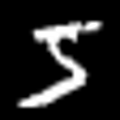

In [3]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [5]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [6]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [7]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs 
# https://pytorch.org/docs/stable/
#########################################################################
# mu = 0.0
# std = 1.0
std, mu = torch.std_mean(ims_train)# default value of "unbiased " is True, using Bessel's correction
print(std)
print(mu)

tensor(0.3081)
tensor(0.1307)


We normalize the data as below.

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [9]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [10]:
BATCH_SIZE = 64
# NUM_WORKERS = 4
NUM_WORKERS = 0
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################
# dl_train = None
# dl_test = None
dl_train = DataLoader(ds_train, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dl_test = DataLoader(ds_test, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [11]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [12]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####
        
        # nLayer is the number of hidden layers
        # FirstLayer = nn.Linear(nInput,nHidden)
        # layers.append(FirstLayer)
        # layers.append(act_fn)
        # for i in range(nLayer):
        #     HiddenLayer = nn.Linear(nHidden,nHidden)
        #     layers.append(HiddenLayer)
        #     layers.append(act_fn)
        # LastLayer = nn.Linear(nHidden,nOutput)
        # layers.append(LastLayer)
        # layers.append(act_fn)
        
        # nLayer is the number of all layers
        if nLayer == 1:
            Layer = nn.Linear(nInput,nOutput)
            layers.append(Layer)
            # layers.append(act_fn)
        elif nLayer == 2:
            FirstLayer = nn.Linear(nInput,nHidden)
            layers.append(FirstLayer)
            layers.append(act_fn)
            LastLayer = nn.Linear(nHidden,nOutput)
            layers.append(LastLayer)
            # layers.append(act_fn)
        else:
            FirstLayer = nn.Linear(nInput,nHidden)
            layers.append(FirstLayer)
            layers.append(act_fn)
            for i in range(nLayer - 2):
                HiddenLayer = nn.Linear(nHidden,nHidden)
                layers.append(HiddenLayer)
                layers.append(act_fn)
            LastLayer = nn.Linear(nHidden,nOutput)
            layers.append(LastLayer)
            # layers.append(act_fn)
        ###############################
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [13]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [14]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

We already implemented the test function for you

In [15]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [16]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### implement this part #####
        output = model.forward(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [17]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [18]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303152
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.652236
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.501715
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.297590
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.160965
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.214616
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.164442
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.189471
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.307243
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.269308

Train set: Average loss: 0.0912, Accuracy: 53051/60000 (88.4%)


Test set: Average loss: 0.2473, Accuracy: 9270/10000 (92.700%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.255072
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.215838
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.146307
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.198121
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.405085
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.249829
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.180887
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [19]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 2
nHidden = 64
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.275114
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.208417
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.341356
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.356464
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.214513
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.221007
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.341218
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.213519
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.169726
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.067806

Train set: Average loss: 0.4784, Accuracy: 54698/60000 (91.2%)


Test set: Average loss: 0.1756, Accuracy: 9470/10000 (94.700%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.143184
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.097758
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.210159
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.299097
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.104022
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.075677
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.235929
Train Epoch: 2 [44800/60000 (75%

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [20]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
                    nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                    nn.Dropout(p=0.25),
                    nn.Flatten(start_dim = 1),
                    nn.Linear(9216,128),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(128,10)         
                    )
         
    def forward(self, x):
        return self.model(x)


In [21]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

In [22]:
optimizer = optim.Adam(cnn.parameters())

In [24]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.013212
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.039028
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.044452
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.027370
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.069535
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.158527
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.083057
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.052572
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.066314
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.011024

Train set: Average loss: 0.0017, Accuracy: 59284/60000 (98.8%)


Test set: Average loss: 0.0324, Accuracy: 9911/10000 (99.110%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.099836
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.011469
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.001534
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.012332
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.027045
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.060666
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.037501
Train Epoch: 2 [44800/60000 (75%

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: 
10%

## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [25]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [26]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [27]:
ims_train.shape

torch.Size([50000, 32, 32, 3])

In [28]:
ims_train.std((0,1,2))

tensor([0.2470, 0.2435, 0.2616])

In [29]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
#mu = 0.0
#std = 1.0
flattened = torch.flatten(ims_train,0,2)
std, mu = torch.std_mean(flattened,0)

In [30]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.4914, 0.4822, 0.4465])

For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [31]:
BATCH_SIZE = 128
# NUM_WORKERS = 4 
NUM_WORKERS = 0
# if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# Train: 
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
# transform_train = None
# transform_test = None

transform_train = transforms.Compose([
    transforms.RandomCrop(size=32,padding=4),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

#dl_train = None
#dl_test = None
dl_train = DataLoader(ds_train, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dl_test = DataLoader(ds_test, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [32]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [33]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [34]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                    nn.Dropout(p=0.25),
                    nn.Flatten(start_dim = 1),
                    nn.Linear(12544,128),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(128,10)         
                    )

    def forward(self, x):
        return self.model(x)    


Let's try again

In [35]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.306418
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.070415
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.130399
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.118514

Train set: Average loss: 2.0942, Accuracy: 9830/50000 (19.7%)


Test set: Average loss: 1.9174, Accuracy: 2719/10000 (27.190%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.049581
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.980296
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.984684
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.974645

Train set: Average loss: 1.8223, Accuracy: 13686/50000 (27.4%)


Test set: Average loss: 1.6870, Accuracy: 3720/10000 (37.200%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.694388
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.826193
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.901740
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.862779

Train set: Average loss: 1.8188, Accuracy: 16579/50000 (33.2%)


Test set: Average loss: 1.5309, Accuracy: 4536/10000 (45.360%)

Train Epoch: 4 [0/50000 (0

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)



If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. 

It as easy as:

In [36]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.292736
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.135919
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.993766
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.962391

Train set: Average loss: 2.0945, Accuracy: 13238/50000 (26.5%)


Test set: Average loss: 1.8113, Accuracy: 3324/10000 (33.240%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.952930
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.550712
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.746538
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.878258

Train set: Average loss: 1.8761, Accuracy: 16262/50000 (32.5%)


Test set: Average loss: 1.5957, Accuracy: 4018/10000 (40.180%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.789910
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.692536
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.644918
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.715625

Train set: Average loss: 1.8186, Accuracy: 17793/50000 (35.6%)


Test set: Average loss: 1.5276, Accuracy: 4389/10000 (43.890%)

Train Epoch: 4 [0/50000 (

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [37]:
from torchvision.models import resnet18

In [38]:
cnn = resnet18()
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we use negative log-likelihood as the training criterion. 

In [39]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################
cnn.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=10, bias=True),
    nn.LogSoftmax()
)
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

D:\Anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([16, 10])

In [41]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.476254
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.875339
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.798871
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.683886

Train set: Average loss: 1.6982, Accuracy: 14903/50000 (29.8%)


Test set: Average loss: 1.5243, Accuracy: 4246/10000 (42.460%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.621186
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.523937
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.493323
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.472289

Train set: Average loss: 1.3489, Accuracy: 22117/50000 (44.2%)


Test set: Average loss: 1.3082, Accuracy: 5231/10000 (52.310%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.406482
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.428717
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.247789
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.256569

Train set: Average loss: 1.3145, Accuracy: 25781/50000 (51.6%)


Test set: Average loss: 1.2543, Accuracy: 5480/10000 (54.800%)

Train Epoch: 4 [0/50000 (

Train Epoch: 26 [12800/50000 (26%)]	Loss: 0.656824
Train Epoch: 26 [25600/50000 (51%)]	Loss: 0.671267
Train Epoch: 26 [38400/50000 (77%)]	Loss: 0.528169

Train set: Average loss: 0.8748, Accuracy: 38066/50000 (76.1%)


Test set: Average loss: 0.8750, Accuracy: 7088/10000 (70.880%)

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.699449
Train Epoch: 27 [12800/50000 (26%)]	Loss: 0.628477
Train Epoch: 27 [25600/50000 (51%)]	Loss: 0.678746
Train Epoch: 27 [38400/50000 (77%)]	Loss: 0.700974

Train set: Average loss: 0.5719, Accuracy: 38038/50000 (76.1%)


Test set: Average loss: 0.7353, Accuracy: 7526/10000 (75.260%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.444976
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.630121
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.688398
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.818863

Train set: Average loss: 0.6543, Accuracy: 38401/50000 (76.8%)


Test set: Average loss: 0.8653, Accuracy: 7130/10000 (71.300%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.718633
Train Epoch: 

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %